# TRAINING AN IMAGE CLASSIFIER
CIFAR10 is a dataset with different images and 10 classes ( ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’).
Every image has size 3x32x32 with convention channel-first (pytorch)
We will do the following:

1) **Load** and **normalize** the CIFAR10 training and test dataset using **torchvision**
2) **Define** a **Convolutional Neural Network (CNN)**
3) **Define** a **loss function** 
4) **Train** the network on training data
5) **Test** the network on test data

# 1) Load and normalize CIFAR10

In [8]:
import sys
print(sys.executable)
print(sys.version)

c:\Users\Utente\OneDrive - Politecnico di Torino\ADVANCED_ML\PYTORCH\venv\Scripts\python.exe
3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:39) [MSC v.1935 64 bit (AMD64)]


In [7]:
import subprocess, sys
print(subprocess.run([sys.executable, "-m", "pip", "show", "torch"], capture_output=True, text=True).stdout)

In [9]:
# Esegui questa cella nel notebook
import sys, subprocess
print("Kernel Python:", sys.executable)
print(sys.version)
print("pip show torch output:")
print(subprocess.run([sys.executable, "-m", "pip", "show", "torch"], capture_output=True, text=True).stdout or "<nessun output>")

Kernel Python: c:\Users\Utente\OneDrive - Politecnico di Torino\ADVANCED_ML\PYTORCH\venv\Scripts\python.exe
3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:39) [MSC v.1935 64 bit (AMD64)]
pip show torch output:
<nessun output>


In [10]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.5.1%2Bcu121-cp312-cp312-win_amd64.whl (2449.3 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp312-cp312-win_amd64.whl (6.1 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp312-cp312-win_amd64.whl (4.1 MB)
  Obtaining dependency information for filelock from https://download.pytorch.org/whl/filelock-3.13.1-py3-none-any.whl.metadata
  Using cached https://download.pytorch.org/whl/filelock-3.13.1-py3-none-any.whl.metadata (2.8 kB)
  Obtaining dependency information for typing-extensions>=4.8.0 from https://download.pytorch.org/whl/typing_extensions-4.12.2-py3-none-any.whl.metadata
  Using cached https://download.pytorch.org/whl/typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Obtaining dependency information for networkx from https://download.pytorch.org/whl/networkx-3.3-py3-none-any

In [11]:
#py -3.12 -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
#get dataset as PILImage and transform to Tensor
#then centralize from [0, 1] to [-1, 1] with Normalization

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #mean e dev std for R, G and B channels
        #x_new = (x - 0.5)/0.5 --> x_new = 2x - 1 
    ]
)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
train_loader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 2) #get batches from dataset, already splitted in train_loader and shuffled at each epoch

testset = torchvision.datasets.CIFAR10(root='./data', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers = 2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


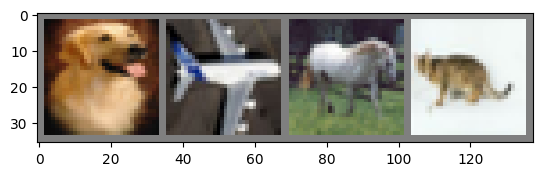

dog	plane	horse	cat	


In [14]:
#visualize image of training set

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img /2 + 0.5 #unnormalize
    npimg = img.numpy() #from tensor to array
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #da channel-first a channel-last di matplotlib
    plt.show()

#get random images from traing set
dataiter = iter(train_loader)
images, labels = next(dataiter)

#show images
imshow(torchvision.utils.make_grid(images))
#print labels
print(''.join(f'{classes[labels[j]]:.5s}\t' for j in range(batch_size)))

# 2) Define CNN

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self): #class torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #from 3 channels of input data, through 6 filters 5x5x3 we construct a feature map of [(N-5)/stride]+1 (here stride 1) --> 28x28x3
        self.pool = nn.MaxPool2d(2, 2) #pool 2x2 stride 2 --> halfening the feature map --> 14x14x6
        self.conv2 = nn.Conv2d(6, 16, 5) #6 channels in input now, and 16 filters 5x5x16 --> 10x10x16
        #in forward (dove effettivamente costruisco rete) APPLICO pool 2x2 stride 2 --> halfening the feature map --> 5x5x16
        self.fc1 = nn.Linear(16 * 5 * 5, 120) #120 neurons --> 120 features in output
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) #10 outputs <--> 10 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # x -> conv1 -> relu -> pool
        x = self.pool(F.relu(self.conv2(x))) # x -> conv2 -> relu -> pool 
        #flatten before Linear Layer
        x = torch.flatten(x, 1)
        #Dopo i due pooling, la shape è (batch_size, 16, 5, 5)
        #Devi trasformarla in (batch_size, 400) per la Linear layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = self.fc3(x) #no activation at the end, but crossentropy loss has softmax inside so we will have 10 probabilities that sum up to 1
        return out

CNN = ConvolutionalNeuralNetwork()


# 3) Defin Loss and Optimizer

In [16]:
from torch import optim

loss_funct = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN.parameters(), lr = 0.001, momentum = 0.9)

# 4) Train CNN

In [38]:
n_epochs = 2

for epoch in range(n_epochs):
    total_loss, tot_samples = 0.0, 0

    for i, batch in enumerate(train_loader, 0):
        images, targets = batch
        tot_samples += images.size(0)

        #zeroing grad for optimizer
        optimizer.zero_grad()

        #make prediciton with forward function on entire batch
        preds = CNN(images)

        #calculate LOSS
        loss = loss_funct(preds, targets) #mean on all images in batch

        #perform backprop to calculate gradients
        loss.backward()

        #update parameters as -lr*gradient
        optimizer.step()

        #calculate loss
        total_loss += loss.item() * images.size(0) #total loss of batch

        if i%2000 == 1999: #print every 2000
            print(f'Average loss of epoch {epoch+1} and batch: {i+1}: {((total_loss*1.0)/float(tot_samples)):.6f}') 

    

print('Training finished')



Average loss of epoch 1 and batch: 2000: 1.209014
Average loss of epoch 1 and batch: 4000: 1.210766
Average loss of epoch 1 and batch: 6000: 1.203821
Average loss of epoch 1 and batch: 8000: 1.205786
Average loss of epoch 1 and batch: 10000: 1.207112
Average loss of epoch 1 and batch: 12000: 1.204406
Average loss of epoch 2 and batch: 2000: 1.117774
Average loss of epoch 2 and batch: 4000: 1.109844
Average loss of epoch 2 and batch: 6000: 1.114648
Average loss of epoch 2 and batch: 8000: 1.114357
Average loss of epoch 2 and batch: 10000: 1.118173
Average loss of epoch 2 and batch: 12000: 1.116196
Training finished


# SAVE RESULTS

In [ ]:
PATH = './saves.pth'
torch.save(CNN.state_dict(), PATH) #state_dict() e un dizionario con i pesi e gli ottimizzatori di ogni layer, accessibili con le chiavi:
#conv1.weights, fc1.bias ecc...

#!caricare
#load = torch.load('saves.pth') 
#CNN.load_state_dict(load) 

# TEST CNN

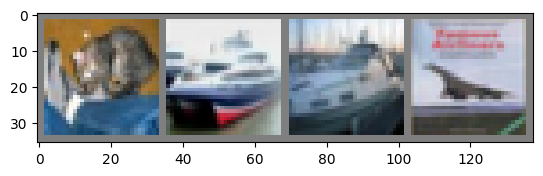

cat	car	car	ship	


In [41]:
#little sample with imshow
#get random images from traing set
dataiter = iter(test_loader)
images, labels = next(dataiter)

#show images
imshow(torchvision.utils.make_grid(images))

outputs = CNN(images)
_, predicted = torch.max(outputs, 1) #take the maximum in a tensor of 1d (class with bigger probability)
#print labels
print(''.join(f'{classes[predicted[j]]:.5s}\t' for j in range(batch_size)))


In [44]:
#test on all testset

correct = 0
total = 0

with torch.no_grad(): #forces pytorch to not compute gradients (we don't need them in test)
    for batch in test_loader:
        images, labels = batch
        outputs = CNN(images)
        _, predicted = torch.max(outputs, 1)
        total += images.size(0)
        correct += (predicted == labels).sum().item() 

print(f'accuracy of predictions: {(100*(1.0*correct)/float(total)):.2f}%')

accuracy of predictions: 59.82%


# PRINT ACCURACY FOR EACH CLASS

In [18]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for batch in test_loader:
        images, labels = batch
        outputs = CNN(images)
        _, predicted = torch.max(outputs, 1)
        for (label, pred) in zip(labels, predicted):
            total_pred[classes[label]] += 1
            if label == pred:
                correct_pred[classes[label]] += 1

for classname in classes:
    print(f'accuracy for {classname}: {(100*(1.0*correct_pred[classname])/float(total_pred[classname])):.2f}%')


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

# TRAINING ON GPU

In [17]:
n_epochs = 2
CNN = CNN.cuda()
# or device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#CNN.to(device)

for epoch in range(n_epochs):
    total_loss, tot_samples = 0.0, 0

    for i, batch in enumerate(train_loader, 0):
        images, targets = batch
        images, targets = images.cuda(), targets.cuda()
        tot_samples += images.size(0)

        #zeroing grad for optimizer
        optimizer.zero_grad()

        #make prediciton with forward function on entire batch
        preds = CNN(images)

        #calculate LOSS
        loss = loss_funct(preds, targets) #mean on all images in batch

        #perform backprop to calculate gradients
        loss.backward()

        #update parameters as -lr*gradient
        optimizer.step()

        #calculate loss
        total_loss += loss.item() * images.size(0) #total loss of batch

        if i%2000 == 1999: #print every 2000
            print(f'Average loss of epoch {epoch+1} and batch: {i+1}: {((total_loss*1.0)/float(tot_samples)):.6f}') 

    

print('Training finished')



Average loss of epoch 1 and batch: 2000: 2.201817
Average loss of epoch 1 and batch: 4000: 2.045355
Average loss of epoch 1 and batch: 6000: 1.919368
Average loss of epoch 1 and batch: 8000: 1.831048
Average loss of epoch 1 and batch: 10000: 1.764981
Average loss of epoch 1 and batch: 12000: 1.717074
Average loss of epoch 2 and batch: 2000: 1.407266
Average loss of epoch 2 and batch: 4000: 1.393326
Average loss of epoch 2 and batch: 6000: 1.381396
Average loss of epoch 2 and batch: 8000: 1.372020
Average loss of epoch 2 and batch: 10000: 1.359388
Average loss of epoch 2 and batch: 12000: 1.344284
Training finished


In [20]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for batch in test_loader:
        images, labels = batch
        images, labels = images.cuda(), labels.cuda()
        outputs = CNN(images)
        _, predicted = torch.max(outputs, 1)
        for (label, pred) in zip(labels, predicted):
            total_pred[classes[label]] += 1
            if label == pred:
                correct_pred[classes[label]] += 1

for classname in classes:
    print(f'accuracy for {classname}: {(100*(1.0*correct_pred[classname])/float(total_pred[classname])):.2f}%')


accuracy for plane: 63.00%
accuracy for car: 69.60%
accuracy for bird: 28.90%
accuracy for cat: 36.30%
accuracy for deer: 50.10%
accuracy for dog: 50.40%
accuracy for frog: 65.40%
accuracy for horse: 66.30%
accuracy for ship: 75.90%
accuracy for truck: 52.10%
